# Crane optimization hands-on task
*Intro info here*

*This is an online Jupyter notebook. Notebooks integrate Python code, text and plots in a single convenient file, split into "cells". To run a cell you simply have to select it and press the "Run" button. It is important that all cells are ran, and in the correct order.* 

First we need some imports and other boilerplate things:

In [38]:
# Enable nice plots:
%matplotlib inline

# Imports:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
import casadi as cs

# Center figures:
from IPython.core.display import HTML
HTML("""
<style>
.output_subarea {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Introducing the problem
For this hands-on task we will consider using <mark>trajectory optimization</mark> to control an overhead crane (*insert Willy Wonka story here*). The crane has a horizontal position $r$ and angle $\theta$, as seen in the figure below. We can push the "cart" with a force $F$ and will try to find a way to decide $F$ over time such that we move the crane system from the "Start" position to the "Target" position. 

<img src="crane_fig.png" alt="crane" width="800"/>

<!-- The states of the system are the position of the cart $r$ and the angle of the pendulum $\theta$, such that $x = \begin{bmatrix} r & \theta \end{bmatrix}^{\top}$.

*Explain more here.* -->

<!-- The dynamics of the overhead crane system can be formulated as:
\begin{equation}
M(x) \ddot{x} + h(x, \dot{x}) = u, 
\end{equation}
where 
\begin{equation}
M(x) = \begin{bmatrix} m_1 + m_2 & m_2 \ell \cos(\theta) \\ m_2 \ell \cos(\theta) & m_2 \ell^2 \end{bmatrix},
\quad h(x, \dot{x}) = \begin{bmatrix} -m_2 \ell \dot{\theta}^2 \sin{\theta} \\ m_2 \ell g \sin{\theta} \end{bmatrix},
\quad u = \begin{bmatrix} F \\ 0 \end{bmatrix}
\end{equation}
and $F$ is the force we push the "cart" with. By optimizing $F$ over time we can achieve our desired motion.

We write down the dynamics symbolically using CasADi:

**This will be deleted.** -->

First the dynamics (physics) of the system will be programmed symbolically:

In [39]:
r = cs.MX.sym('r')
theta = cs.MX.sym('theta')
r_dot = cs.MX.sym('r_dot')
theta_dot = cs.MX.sym('theta_dot')
x = cs.vertcat(r, theta, r_dot, theta_dot)

u = cs.MX.sym('F')

m_1 = 5.0  # mass of cart
m_2 = 1.0  # mass of pendulum
l = 1.0    # length of pendulum
g = 9.81   # gravity

M_inv = cs.MX(2,2)
M_inv[0,0] = m_2 * l**2
M_inv[0,1] = - m_2 * l * cs.cos(theta)
M_inv[1,0] = - m_2 * l * cs.cos(theta)
M_inv[1,1] = m_1 + m_2
M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

h = cs.MX(2,1)
h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
h[1,0] = m_2 * l * g * cs.sin(theta)

x_dot = cs.vertcat(x[2:], M_inv @ (cs.vertcat(u, 0) - h))
f = cs.Function('f', [x, u], [x_dot])

<!-- The dynamics described above are however continuous. We want to discretize the problem into steps of length $\Delta T$, such that we have a finite number of optimization variables:
\begin{equation}
\ddot{x} = f(x, \dot{x}, u) \quad \rightarrow \quad \dot{x}_{k+1} = f_d(x_k, \dot{x}_k, u_k)
\end{equation}
Without going into further detail on discretization methods, we apply the much used Runge Kutta 4 (RK4) method in order to get $f_d$: -->

In [40]:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

dt = 0.05
x_0 = np.array([-0.5, 0.0, 0.0, 0.0])

f_d = cs.Function('f', [x, u], [integrate_RK4(x, u, f, dt)])

<!-- *Need to show problem we are formulating and explain NLPs briefly* -->

<!-- \begin{aligned}
    \min_{u} \quad & \sum_{i=0}^{N-1}{R_r (r_i - r_t)^2 + R_\theta \theta_i^2} + R_{\dot{r}} \dot{r}_i^2 + R_{\dot{\theta}} \dot{\theta}_i^2 \\
    \textrm{s.t.} \quad & x_{k+1} = f_d(x_k, u_k) \quad \forall k = 0, 1, \dots, N-1 \\
    & x_0 = x(k)    \\
\end{aligned} -->

<div class="alert alert-block alert-warning">
<b>Trajectory optimization, briefly:</b>
Optimization is a general framework for minimizing/maximizing some function (subsequently called a cost function), while adhering to constraints. In trajectory optimization we apply optimization to find some optimal trajectory/path for a system, such as a robot, drone, rocket, or in our case, crane. By designing a cost function such that some performance metric for the system is minimized, while considering the dynamics of our system and possibly additional constraints, this can be achieved.
</div>

For our first example we will simply tell the optimizer to minimize the distance to our target position. We write this mathematically like this:
$$R_r (r - r_t)^2 + R_\theta \theta^2.$$
Since this function is to be minimized, we simultaneously try to bring the position $r$ to the target $r_t$, while also bringing the angle $\theta$ to the down position (zero). $R_r$ and $R_\theta$ are weights that describe how we weigh these two goals against each other.

Let's add some code for optimizing the motion of the crane (don't bother reading it unless you're interested). We will find the force input to the crane over a time horizon of 4 seconds.

In [41]:
N = 80  # Number of control segments
r_t = 0.5  # target position

def optimize_crane(N, x_0, r_t, R_u=None, use_term_constraint=False, u_max=None, theta_max=None):
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    if R_u is None: R_u = 0
    if u_max is None: u_max = cs.inf

    # Objective function and constraints
    J_k = cs.Function('J_k', [x, u], [R_r*(x[0] - r_t)**2 + R_theta*x[1]**2 + R_r_dot*x[2]**2 + R_theta_dot*x[3]**2 + R_u*u**2])

    # Start with an empty NLP
    w = []
    w0 = np.zeros(N)
    lbw = []
    ubw = []
    J = 0
    g = []
    lbg = []
    ubg = []

    X_k = cs.MX(x_0)
    for k in range(N):
        # Control variable at step k:
        U_k = cs.MX.sym('U_' + str(k))
        w += [U_k]
        
        # Control input bounds:
        lbw += [-u_max]
        ubw += [u_max]

        # Integrate:
        X_k = f_d(X_k, U_k)
        J += dt * J_k(X_k, U_k)

        # State constraint:
        if theta_max is not None:
            g += [X_k[1]]
            lbg += [-theta_max]
            ubg += [theta_max]

    # Terminal constraint:
    if use_term_constraint:
        g += [X_k[0] - r_t]
        g += [X_k[1:]]
        lbg += [0, 0, 0, 0]
        ubg += [0, 0, 0, 0]

    # Create an NLP solver:
    nlp = {'f': J, 'x': cs.vertcat(*w), 'g': cs.vertcat(*g)}
    opts = {'ipopt.print_level':0, 'print_time':0}
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

    # Solve the NLP:
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    u_sol = sol['x']
    return u_sol

We can then simulate the system with the input we calculate using the optimization algorithm:

In [42]:
N_sim = 1000
dt_sim = 0.005

def simulate_crane(x_0, u):
    k_u = int(dt/dt_sim)
    x_sim = np.zeros((N_sim+1,4))
    x_sim[0,:] = x_0
    u_sim = np.zeros(N_sim)
    for k in range(N_sim):
        if k < k_u * N: u_sim[k] = u[int(k/k_u)]
        x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()
    return x_sim, u_sim

Finally we need some code for plotting the simulation results:

In [43]:
mpl.rcParams['lines.linewidth'] = 2

def plot_results(x_sim, u_sim, u_max=None, theta_max=None):
    t = np.array([dt_sim*i for i in range(N_sim)])
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.step(t, u_sim, where='post', c='teal')
    if u_max is not None:
        ax.plot([0, np.max(t)], u_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
        ax.plot([0, np.max(t)], -u_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
    ax.set_title('Force input')
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$F$ (N)')

    fig, ax = plt.subplots(2,2, figsize=(10,5))
    fig.suptitle('States')
    
    ax[0,0].plot(t, x_sim[:N_sim,0], c='mediumblue')
    ax[0,0].plot([0, np.max(t)], r_t * np.ones(2), '--', c='crimson', alpha=0.7)
    ax[0,0].set_ylabel(r'$x$ (m)')
    ax[0,0].set_xlabel(r'$t$ (s)')
    
    ax[0,1].plot(t, x_sim[:N_sim,1], c='mediumblue')
    ax[0,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    if theta_max is not None:
        ax[0,1].plot([0, np.max(t)], theta_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
        ax[0,1].plot([0, np.max(t)], -theta_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
    ax[0,1].set_ylabel(r'$\theta$ (rad)')
    ax[0,1].set_xlabel(r'$t$ (s)')

    ax[1,0].plot(t, x_sim[:N_sim,2], c='mediumblue')
    ax[1,0].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    ax[1,0].set_ylabel(r'$\dot{x}$ (m/s)')
    ax[1,0].set_xlabel(r'$t$ (s)')
    
    ax[1,1].plot(t, x_sim[:N_sim,3], c='mediumblue')
    ax[1,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    ax[1,1].set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax[1,1].set_xlabel(r'$t$ (s)')

    plt.show()

And create a simple animation to better see what is going on:

In [44]:
from IPython.display import HTML

def show_animation():
    skips = 10
    frames = int(N_sim / skips)
    delay = skips*dt_sim*1e3

    rect_height = 0.15
    beam_height = 0.05
    radius = 750

    fig, ax = plt.subplots(figsize=(8,5))

    line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', alpha=0.7, lw=1.5)
    rect_1 = ax.add_patch(Rectangle((0 - 1, 0 - 0.5*beam_height), 2, beam_height, facecolor='firebrick', edgecolor='k', lw=2))
    rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.0 - 0.5*rect_height), 0.4, rect_height, facecolor='indianred', edgecolor='k', lw=2))

    x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
    y_pendulum = -l * np.cos(x_sim[0,1])
    line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
    point_1 = ax.scatter(x_pendulum, y_pendulum, s=radius, facecolors='darkorange', edgecolors='k', lw=2)

    line_3, = ax.plot([-0.5, -0.5], [-1,0], 'k--', alpha=0.7, lw=1.5)
    line_4, = ax.plot([0.5, 0.5], [-1,0], 'k--', alpha=0.7, lw=1.5)

    plt.axis('equal')
    plt.xlim([-1, 1])
    plt.ylim([-1.35, 0.35])

    def animate(i):
        rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
        
        x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
        y_pendulum = -l * np.cos(x_sim[skips*i,1])
        
        point_1.set_offsets([x_pendulum, y_pendulum])
        line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
        
        return line_2, point_1, rect_2
    
    plt.close()

    return animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

Now we plot and animate the results from our first test where we only try to bring the crane to the target position:

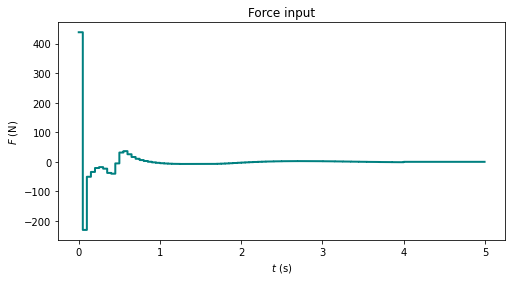

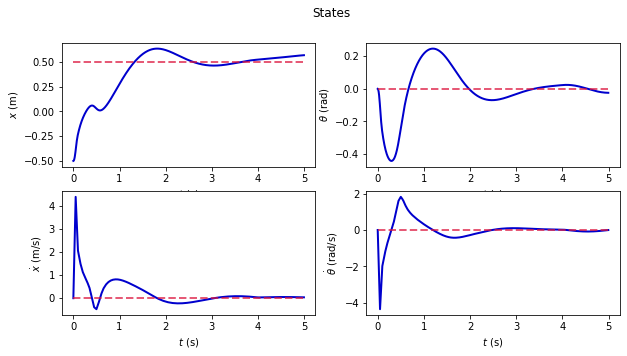

In [45]:
u_sol = optimize_crane(N, x_0, r_t)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)

Run the next cell to display the crane animation (it takes a few seconds):

In [46]:
HTML(show_animation().to_jshtml())

We see that initially the crane jumps forward with a very large force. This would not be good for our crane and would probably not pass the safety requirements at the chocolate factory...

We can therefore not only tell our optimizer to go to the desired position, but also at the same time try to minimize how much force we are using. This will hopefully give us smoother crane motions. We can weigh the goal of reaching the target vs. the goal of reducing the force using a weighing parameter.

Try to change the value of the force weight (to e.g. 0.01, 0.1, 1, 10,...) in the code block below and see how it affects the resulting motion. Try to find a suitable value that weights the two tasks against each other appropriately.

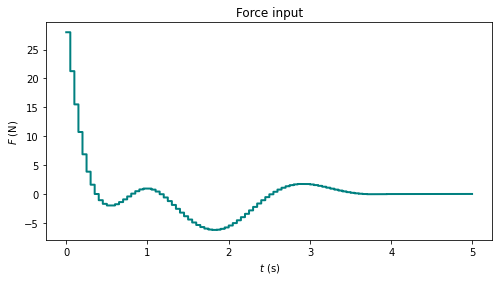

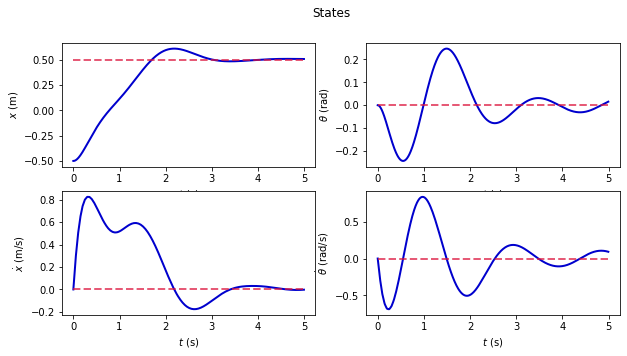

In [47]:
### Try to change the force weight and see the effect:

force_weight = 0.1

###

u_sol = optimize_crane(N, x_0, r_t, R_u=force_weight)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

That hopefully looks much smoother. For the remaining tests we will use a weight of 0.1.

***

### Adding a terminal constraint:
But we have another problem: the crane pendulum doesn't hit our target exactly! It wiggles around, ideally we want it to end perfectly at rest... 

One way of solving this is to add a <mark>terminal constraint</mark>. This means that we constrain the position and angle of our crane on the final time step at $t = 4s$ to be exactly at the target, while also saying that the final velocity should be zero. This can be written like:
$$r_f = r_t, \quad \theta_f = 0, \quad v_f = \omega_f = 0,$$
where $r_f$ and $\theta_f$ is the final position and final angle, respectively, and $v_f$ and $\omega_f$ is the final linear and angular velocity, respectively.

Let's try out the example again, now with this terminal constraint added:

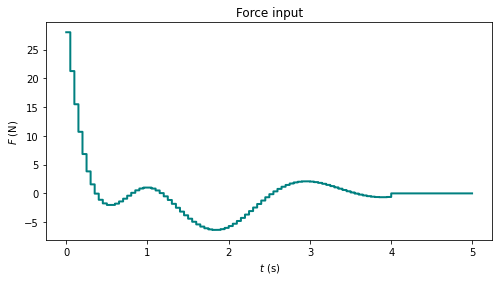

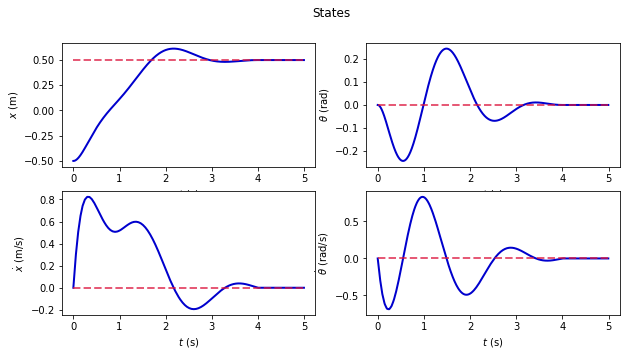

In [48]:
force_weight = 0.1
u_sol = optimize_crane(N, x_0, r_t, R_u=force_weight, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

Now we are getting somewhere! It ends perfectly at rest in the target position!

### Adding input constraints:

Ok, but what if we have a maximum force we can push the cart with? One of the main reasons why optimization is so popular in robotics applications is that such constraints can be seamlessly added to the optimization problem!

We add constraints on the form:
$$-F_{\textrm{max}} \leq F \leq F_{\textrm{max}},$$
meaning that the force should stay within a range specificed by the max force $F_{\textrm{max}}$. Let's set this max value to 3 N of force.

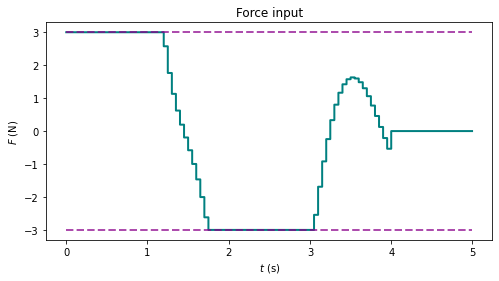

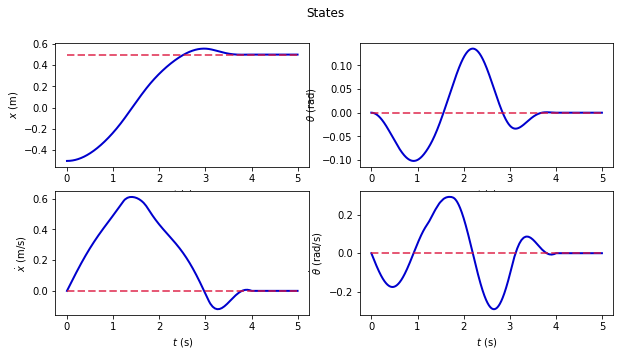

In [49]:
u_max = 3.0
u_sol = optimize_crane(N, x_0, r_t, R_u=force_weight, use_term_constraint=True, u_max=u_max)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim, u_max=u_max)
HTML(show_animation().to_jshtml())

From the first plot we see that now the force is restricted to $[-3,3]$, while still achieving the main goal!

### Adding state constraints:
Now you may ask, can we do the same with the state variables? Yes, we can! Eg. what if we want to limit the angle $\theta$ as well? We can write the constraint like this:
$$-\theta_{\textrm{max}} \leq \theta \leq \theta_{\textrm{max}},$$
and say we for instance want to limit the angle to $\theta_{\textrm{max}} = 4 \ \textrm{deg}$. Let's run another example with this constraint added (instead of the input constraint):

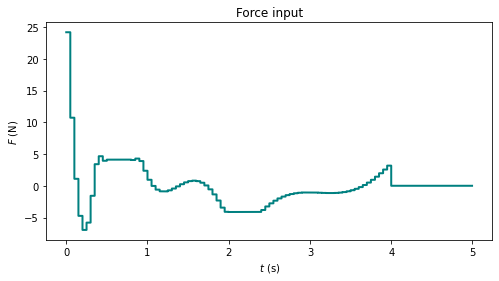

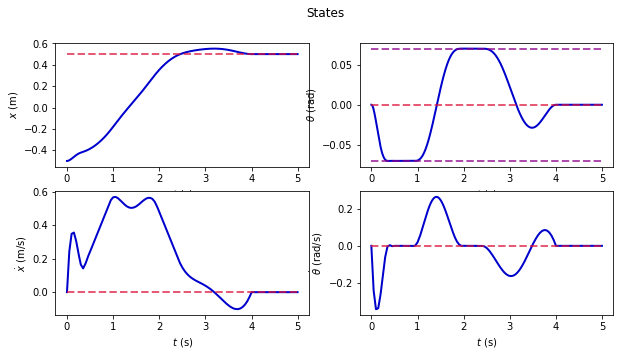

In [50]:
theta_max = np.deg2rad(4)
u_sol = optimize_crane(N, x_0, r_t, R_u=force_weight, use_term_constraint=True, theta_max=theta_max)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim, theta_max=theta_max)
HTML(show_animation().to_jshtml())

Nice! From the top right plot of $\theta$ we see we are able to keep the angle of the crane pendulum within the specified limits. 